# BRAIN TUMOR DETECTION AND CLASSIFICATION

## Import the necessary libraries

In [1]:
import tensorflow as tf
print("Tensor version" + tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ReLU, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import cv2
from tqdm import tqdm

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, VGG19, EfficientNetB1, EfficientNetB2
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

import warnings
#To Suppress Python warnings
warnings.filterwarnings("ignore")

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '2' mutes INFO and WARNING messages, '3' mutes all messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # This will show only TensorFlow ERROR messages

2023-09-10 13:12:45.574602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensor version2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading the Trainig and Testing Data

In [2]:
#  Function to load brain tumor data from the directory

def load_brain_tumor_data(base_dir='./brain tumor dataset/', image_size=150):
    """
    The Parameters 'base_dir (str)' contains the base directory path containing the training and testing folders and 
    'image_size (int)' is the size to which images are resized
    
    The function will return X_train Numpy Array containing X_train images and y_train numpy array containing
    the y_train labels
    """
    
    X_train = []  # List to store images
    y_train = []  # List to store corresponding labels
    labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Defined set of labels
    
    try:
        # Loading training data
        for label in labels:
            folderPath = os.path.join(base_dir, 'Training', label)  # Constructing path to training data for current label
            
            # Iterating through each image in the directory
            for img_name in tqdm(os.listdir(folderPath)):
                img_path = os.path.join(folderPath, img_name)  # Constructing full path to the image
                img = cv2.imread(img_path)  # Reading the image
                img = cv2.resize(img, (image_size, image_size))  # Resizing the image to desired size
                X_train.append(img)  # Appending the image to the list
                y_train.append(label)  # Appending the corresponding label to the list

        # Loading testing data
        for label in labels:
            folderPath = os.path.join(base_dir, 'Testing', label)  # Constructing path to testing data for current label
            
            # Iterating through each image in the directory
            for img_name in tqdm(os.listdir(folderPath)):
                img_path = os.path.join(folderPath, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (image_size, image_size))
                X_train.append(img)
                y_train.append(label)

        # Converting lists to numpy arrays for efficient computataion
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        return X_train, y_train
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None


In [3]:
# Calling the funtion to load the data and assigning them to their labels
X, y = load_brain_tumor_data()
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

100%|██████████| 74/74 [00:00<00:00, 174.35it/s]


### Visualising samples of the data from each class before preprocessing

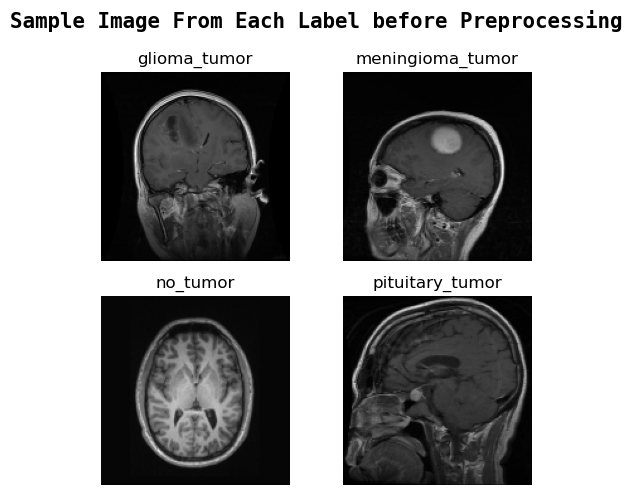

In [10]:
# Setting up the figure and subplots for a 2x2 grid of images
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

# Adding title for the entire figure
fig.suptitle('Sample Image From Each Label before Preprocessing', size=15, fontweight='bold', fontname='monospace')

# Index to track the current subplot
k = 0

# Iterating over each unique label
for label in labels:
    # Searching for the first image with the current label
    for idx, i in enumerate(y):
        if i == label:
            # Getting the row and column indices for the 2x2 subplot grid
            row = k // 2
            col = k % 2
            
            # Displaying the image in the appropriate subplot
            ax[row, col].imshow(X[idx])
            ax[row, col].set_title(i)
            ax[row, col].axis('off')
            
            # Increasing the subplot index
            k += 1
            
            # break out of the loop once an image is displayed for the label 
            break

# Display the figure
plt.tight_layout()
plt.savefig('brain_tumor_image_before_preprocessing.png', dpi=300, bbox_inches='tight')
plt.show()


In [5]:
# Shuffling the data (X) and labels (y) together using a fixed random seed (101) to ensure reproducibility

X, y = shuffle(X, y, random_state=101)

In [6]:
X.shape # Checking the dimensions of the images

(3264, 150, 150, 3)

In [7]:
y.shape

(3264,)

## Image Preprocessing

In [8]:
 # Normalization

# Splitting the data before normalization and encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                  stratify=y, random_state=42)

# Normalization for the training data
X_train = X_train.astype('float32') / 255.0

# Normalization for the test data
X_test = X_test.astype('float32') / 255.0

# Label Encoding followed by One-hot Encoding for training labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_onehot = to_categorical(y_train_encoded)

# Label Encoding followed by One-hot Encoding for test labels
y_test_encoded = label_encoder.transform(y_test)
y_test_onehot = to_categorical(y_test_encoded)


### Sample image for each class after normalization

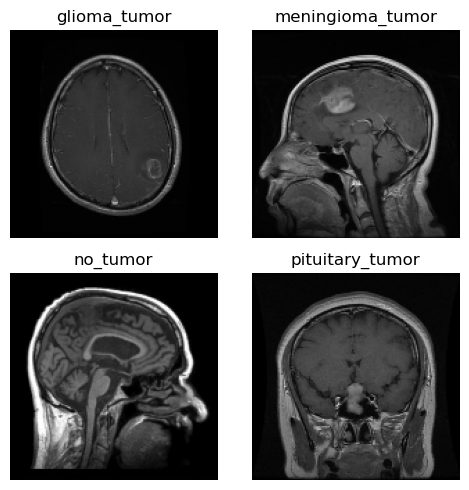

In [9]:
unique_classes = np.unique(y_train)
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for cl, ax in zip(unique_classes, axes.ravel()):
    # Finds the index of the first occurrence of this class
    index = np.where(y_train == cl)[0][0]
    
    # Plot the image of this index
    ax.imshow(X_train[index])
    ax.set_title(cl)
    ax.axis('off')

plt.tight_layout()
plt.savefig('brain_tumor_image_after_preprocessing.png', dpi=300, bbox_inches='tight')
plt.show()

Visually, there will be no difference between unnormalized  and normalized  images that have been rescaled with Min-Max scaler since tools will usually display pixel values in the 0 to 255 range. However, the underlying pixel values have been reduced and transformed to the 0 and 1 range.

## Building and training the simple 2D CNN Baseline Model

In [10]:
# Model Architecture and Compilation
baseline_model = Sequential()

baseline_model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
baseline_model.add(MaxPooling2D(2, 2))

baseline_model.add(Conv2D(16, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(2, 2))

baseline_model.add(Conv2D(16, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(2, 2))

baseline_model.add(Flatten())
baseline_model.add(Dense(16, activation='relu'))
baseline_model.add(Dense(4, activation='softmax')) # 4 classes hence the softmax activation function 

baseline_model.summary()

# Create an instance of the Adam optimizer
optimizer = Adam(learning_rate=0.01)  # Using a learning rate of 0.01

baseline_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# train the model
start_time = time.time()

history = baseline_model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=10, batch_size=64, 
                             callbacks=[checkpoint], verbose=1) # Setting verbose=1 for progress bar

end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The baseline model training took {minutes} minutes and {seconds} seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 16)       0

### The baseline model's performance on the validation set

In [11]:
# Validation accuracy and loss
val_loss, val_acc = baseline_model.evaluate(X_test, y_test_onehot)
print(f"Baseline Model Validation accuracy: {val_acc*100:.2f}%")
print(f"Baseline Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 5ms/step - loss: 0.7346 - accuracy: 0.7152
Baseline Model Validation accuracy: 71.52%
Baseline Model Validation loss: 0.7346


### Plotting the Baseline Model Training & Validation accuracy and loss

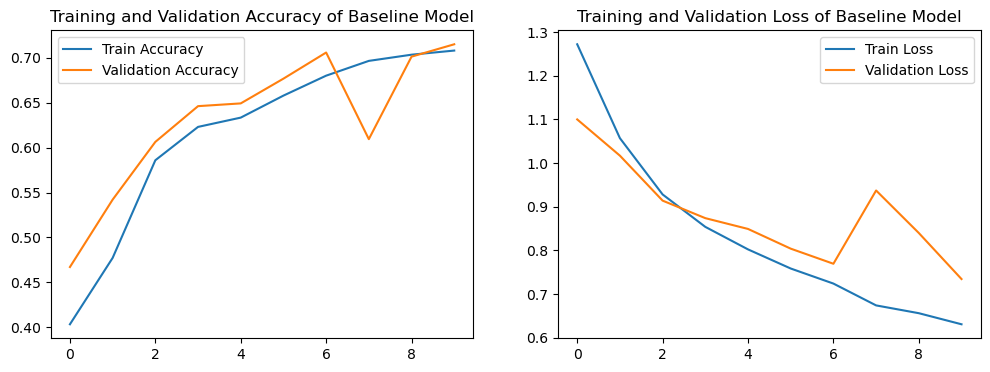

In [12]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of Baseline Model')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss of Baseline Model')

# Save the figure
plt.savefig('baseline_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


### Baseline model Confusion matrix and Classification Report

In [13]:
y_pred = baseline_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 4ms/step


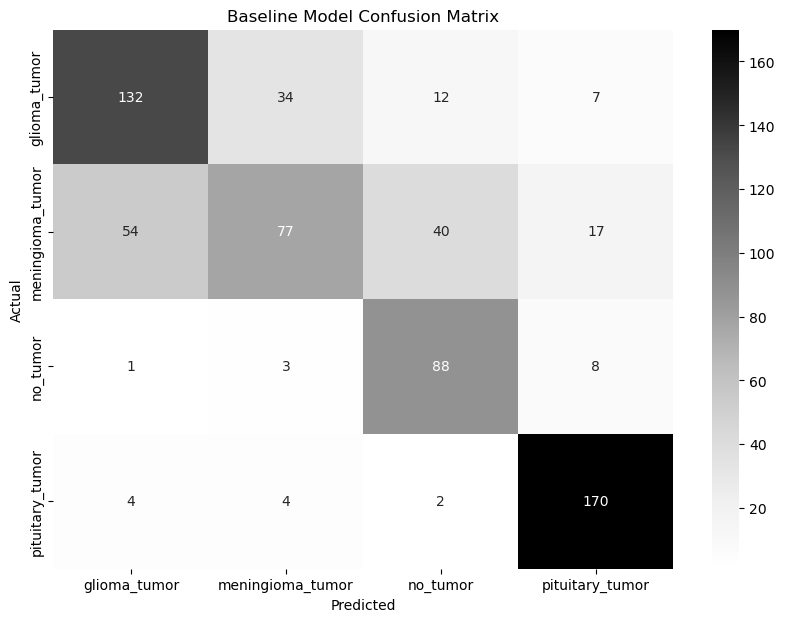

In [14]:
# The baseline model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greys',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model Confusion Matrix')

# Save the figure
plt.savefig('baseline_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# The baseline model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))


                  precision    recall  f1-score   support

    glioma_tumor       0.69      0.71      0.70       185
meningioma_tumor       0.65      0.41      0.50       188
        no_tumor       0.62      0.88      0.73       100
 pituitary_tumor       0.84      0.94      0.89       180

        accuracy                           0.72       653
       macro avg       0.70      0.74      0.71       653
    weighted avg       0.71      0.72      0.70       653



###  Introducing Data Augmentation, Regularization, Dropout, Batch Normalization and Hyperparameter tuninig to the Baseline Model 

In [10]:
# Augmenting the Data
datagen = ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images in the range (0 to 180 degrees)
    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    zoom_range=0.2,          # Randomly zoom image 
    horizontal_flip=True,    # Randomly flip images horizontally
)

datagen.fit(X_train)

### Hyperparameter Tuning and Augmentation

### Tuned Model 1:  ARCHITECTURE AND COMPILATION
**Regularization** Batch Normalization, Dropout 0.5, and L2 

**Optimizer** Adam

**Learning** rate 0.0001  

**Batch size** 16

**Convolutional layers** 3 conv blocks 32, 64, 128, and dense layer of 128

**Epochs** 50 

In [15]:
# Initialize the model
tuned_model = Sequential()

# Add the convolutional layer with L2 regularization
tuned_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model.add(MaxPooling2D((2, 2)))
tuned_model.add(BatchNormalization())  # Batch Normalization

tuned_model.add(Conv2D(64, (3, 3), activation='relu'))
tuned_model.add(MaxPooling2D((2, 2)))
tuned_model.add(BatchNormalization())  # Batch Normalization

tuned_model.add(Conv2D(128, (3, 3), activation='relu'))
tuned_model.add(MaxPooling2D((2, 2)))
tuned_model.add(BatchNormalization())  # Batch Normalization

# Flatten the layer
tuned_model.add(Flatten())

# Add dense layers with dropout and L2 regularization
tuned_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
tuned_model.add(Dropout(0.5))
tuned_model.add(Dense(4, activation='softmax'))

# Create an instance of the Adam optimizer
optimizer = Adam(learning_rate=0.0001)  # Using a learning rate of 0.0001

tuned_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

tuned_model.summary()

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# training with the augumented data
start_time = time.time()

tuned_history = tuned_model.fit(datagen.flow(X_train, y_train_onehot, batch_size=16),
                             validation_data=(X_test, y_test_onehot),
                             epochs=50,
                             callbacks=[checkpoint], 
                             verbose=1)

end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The Augmented tuned model training took {minutes} minutes and {seconds} seconds")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 74, 74, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                      

164/164 [==============================] - 10s 63ms/step - loss: 0.9037 - accuracy: 0.7269 - val_loss: 3.2057 - val_accuracy: 0.5222
Epoch 41/50
164/164 [==============================] - 10s 64ms/step - loss: 0.9221 - accuracy: 0.7315 - val_loss: 1.9403 - val_accuracy: 0.6217
Epoch 42/50
164/164 [==============================] - 10s 62ms/step - loss: 0.9078 - accuracy: 0.7338 - val_loss: 5.1046 - val_accuracy: 0.5237
Epoch 43/50
164/164 [==============================] - 10s 63ms/step - loss: 0.9044 - accuracy: 0.7346 - val_loss: 2.2405 - val_accuracy: 0.6110
Epoch 44/50
164/164 [==============================] - 10s 63ms/step - loss: 0.9115 - accuracy: 0.7277 - val_loss: 1.0457 - val_accuracy: 0.7213
Epoch 45/50
164/164 [==============================] - 11s 65ms/step - loss: 0.8676 - accuracy: 0.7422 - val_loss: 1.1560 - val_accuracy: 0.7351
Epoch 46/50
164/164 [==============================] - 10s 63ms/step - loss: 0.8746 - accuracy: 0.7334 - val_loss: 0.7606 - val_accuracy: 0.79

In [16]:
# Validation accuracy and loss
val_loss, val_acc = tuned_model.evaluate(X_test, y_test_onehot)
print(f"Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"Tuned Model Validation loss: {val_loss:.4f}")

21/21 [==============================] - 0s 5ms/step - loss: 1.3748 - accuracy: 0.6753
Tuned Model Validation accuracy: 67.53%
Tuned Model Validation loss: 1.3748


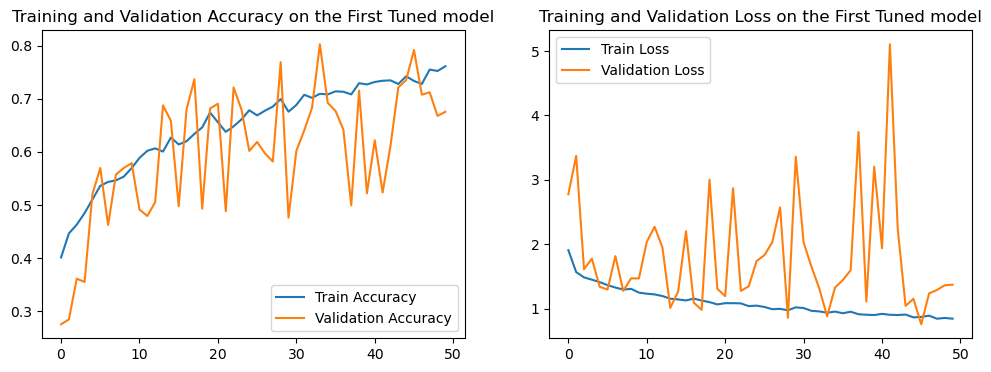

In [17]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tuned_history.history['accuracy'], label='Train Accuracy')
plt.plot(tuned_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy on the First Tuned model')

plt.subplot(1, 2, 2)
plt.plot(tuned_history.history['loss'], label='Train Loss')
plt.plot(tuned_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss on the First Tuned model')

# Save the figure
plt.savefig('first_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
y_pred = tuned_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 4ms/step


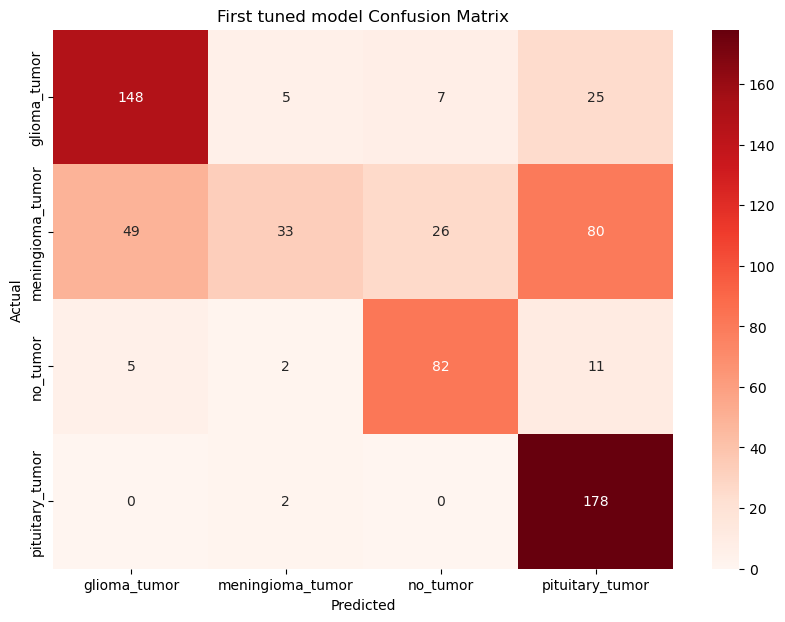

In [19]:
# The tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('First tuned model Confusion Matrix')
# Save the figure
plt.savefig('first_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# The tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.73      0.80      0.76       185
meningioma_tumor       0.79      0.18      0.29       188
        no_tumor       0.71      0.82      0.76       100
 pituitary_tumor       0.61      0.99      0.75       180

        accuracy                           0.68       653
       macro avg       0.71      0.70      0.64       653
    weighted avg       0.71      0.68      0.62       653



### OBSERVATION:

## Tuned Model 2:  ARCHITECTURE AND COMPILATION
**Regularization** Batch Normalization, Dropout 0.5, and L2 

**Optimizer** Adam

**Learning** rate 0.0001  

**Batch size** 16

**Convolutional layers** 4 conv blocks 32, 64, 128, 256 and dense layer of 256

**Epochs** 50 

In [12]:
# Initialize the model
tuned_model2 = Sequential()

# Add the convolutional layer with L2 regularization
tuned_model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model2.add(MaxPooling2D((2, 2)))
tuned_model2.add(BatchNormalization())  # Batch Normalization

tuned_model2.add(Conv2D(64, (3, 3), activation='relu'))
tuned_model2.add(MaxPooling2D((2, 2)))
tuned_model2.add(BatchNormalization())  # Batch Normalization

tuned_model2.add(Conv2D(128, (3, 3), activation='relu'))
tuned_model2.add(MaxPooling2D((2, 2)))
tuned_model2.add(BatchNormalization())  # Batch Normalization

tuned_model2.add(Conv2D(256, (3, 3), activation='relu'))
tuned_model2.add(MaxPooling2D((2, 2)))
tuned_model2.add(BatchNormalization())  # Batch Normalization

# Flatten the layer
tuned_model2.add(Flatten())

# Add dense layers with dropout and L2 regularization
tuned_model2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
tuned_model2.add(Dropout(0.5))
tuned_model2.add(Dense(4, activation='softmax'))

tuned_model2.summary()

# Create an instance of the Adam optimizer
optimizer = Adam(learning_rate=0.0001)  # Using a learning rate of 0.0001

tuned_model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# training with the augumented data
start_time = time.time()

tuned_history2 = tuned_model2.fit(datagen.flow(X_train, y_train_onehot, batch_size=16),
                             validation_data=(X_test, y_test_onehot),
                             epochs=50,
                             callbacks=[checkpoint], 
                             verbose=1)

end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The Second Tuned Model training took {minutes} minutes and {seconds} seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                        

In [13]:
# Validation accuracy and loss
val_loss, val_acc = tuned_model2.evaluate(X_test, y_test_onehot)
print(f"The Second Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"The Second Tuned Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 6ms/step - loss: 1.7539 - accuracy: 0.6401
The Second Tuned Model Validation accuracy: 64.01%
The Second Tuned Model Validation loss: 1.7539


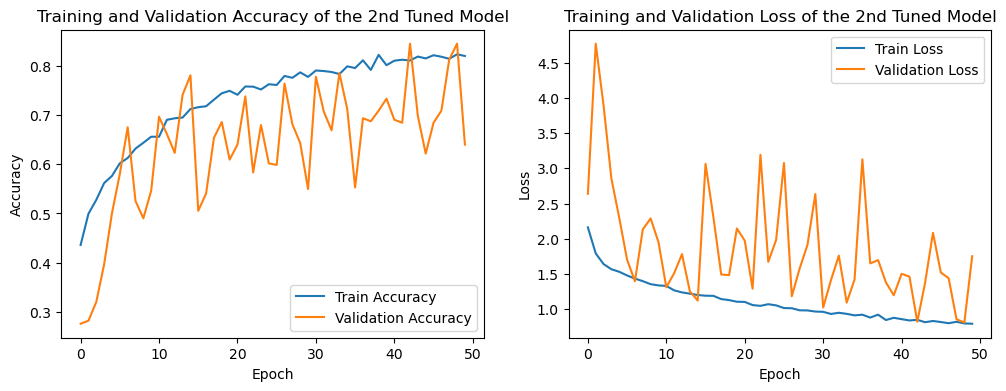

In [14]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tuned_history2.history['accuracy'], label='Train Accuracy')
plt.plot(tuned_history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of the 2nd Tuned Model')

plt.subplot(1, 2, 2)
plt.plot(tuned_history2.history['loss'], label='Train Loss')
plt.plot(tuned_history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of the 2nd Tuned Model')

# Save the figure
plt.savefig('second_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
y_pred = tuned_model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 5ms/step


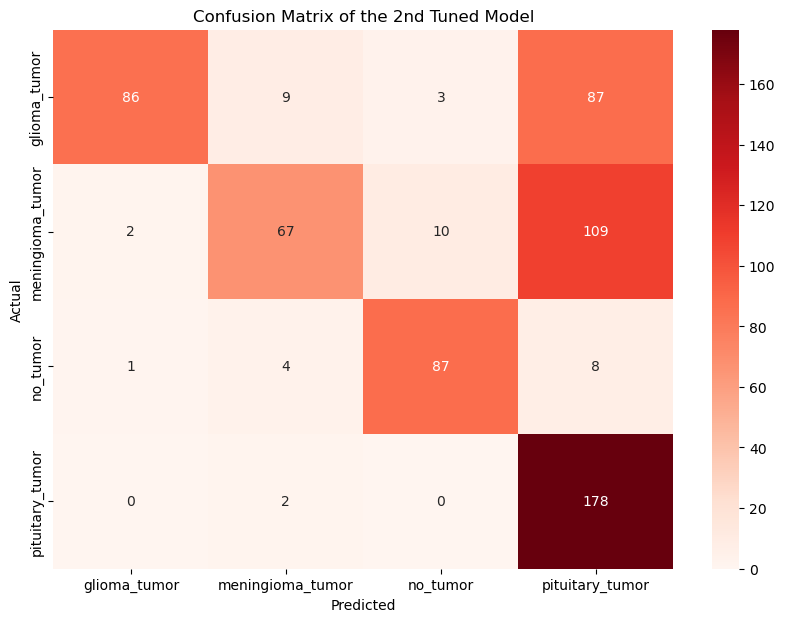

In [16]:
# The second tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the 2nd Tuned Model')
# Save the figure
plt.savefig('second_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# The second tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.46      0.63       185
meningioma_tumor       0.82      0.36      0.50       188
        no_tumor       0.87      0.87      0.87       100
 pituitary_tumor       0.47      0.99      0.63       180

        accuracy                           0.64       653
       macro avg       0.78      0.67      0.66       653
    weighted avg       0.77      0.64      0.63       653



### OBSERVATION: 

## Tuned Model 3:  ARCHITECTURE AND COMPILATION
**Reduced Regularization** Dropout 0.5

**Optimizer** Adam

**Learning** default Adam learning rate 0.001  

**Batch size** 32

**Convolutional layers** 3 conv blocks 32, 64, 128 and dense layer of 256

**Epochs** 20 

In [27]:
tuned_model3 = Sequential()

tuned_model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model3.add(MaxPooling2D(2, 2))

tuned_model3.add(Conv2D(64, (3, 3), activation='relu'))
tuned_model3.add(MaxPooling2D(2, 2))

tuned_model3.add(Conv2D(128, (3, 3), activation='relu'))
tuned_model3.add(MaxPooling2D(2, 2))

tuned_model3.add(Flatten())
tuned_model3.add(Dense(256, activation='relu'))
tuned_model3.add(Dropout(0.5))
tuned_model3.add(Dense(4, activation='softmax')) # 4 classes hence the softmax activation function 

tuned_model3.summary()

tuned_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

start_time = time.time()

tuned_history3 = tuned_model3.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                             validation_data=(X_test, y_test_onehot),
                             epochs=20,
                             callbacks=[checkpoint], 
                             verbose=1)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The third Tuned model training took {minutes} minutes and {seconds} seconds")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 128)     

In [28]:
# Validation accuracy and loss
val_loss, val_acc = tuned_model3.evaluate(X_test, y_test_onehot)
print(f"The third Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"The third Tuned Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 5ms/step - loss: 0.6475 - accuracy: 0.7427
The third Tuned Model Validation accuracy: 74.27%
The third Tuned Model Validation loss: 0.6475


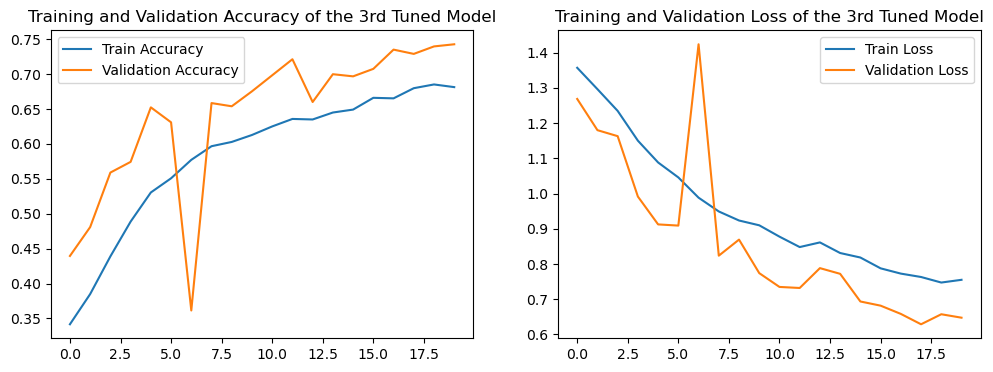

In [29]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tuned_history3.history['accuracy'], label='Train Accuracy')
plt.plot(tuned_history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of the 3rd Tuned Model')

plt.subplot(1, 2, 2)
plt.plot(tuned_history3.history['loss'], label='Train Loss')
plt.plot(tuned_history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss of the 3rd Tuned Model')

# Save the figure
plt.savefig('third_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
y_pred = tuned_model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 4ms/step


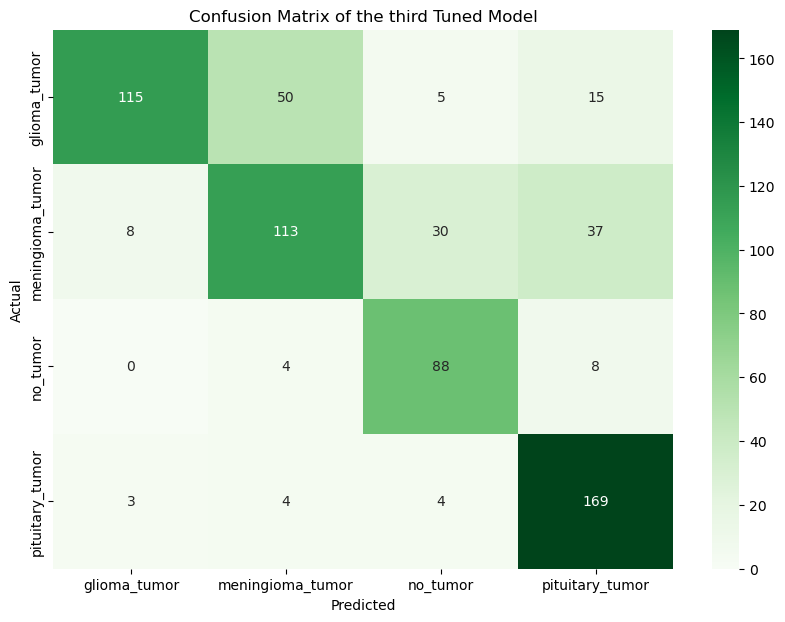

In [31]:
# The third tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the third Tuned Model')
# Save the figure
plt.savefig('third_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# The third tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.62      0.74       185
meningioma_tumor       0.66      0.60      0.63       188
        no_tumor       0.69      0.88      0.78       100
 pituitary_tumor       0.74      0.94      0.83       180

        accuracy                           0.74       653
       macro avg       0.75      0.76      0.74       653
    weighted avg       0.76      0.74      0.74       653



## Tuned Model 4: 
**Reduced Regularization** Dropout 0.5

**Optimizer** Adam

**Learning** default Adam learning rate 0.001  

**Batch size** 32

**Convolutional layers** 4 conv blocks 64, 128, 256, 512 and dense layer of 512

**Epochs** 50 

In [33]:
tuned_model4 = Sequential()

tuned_model4.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model4.add(MaxPooling2D(2, 2))

tuned_model4.add(Conv2D(128, (3, 3), activation='relu'))
tuned_model4.add(MaxPooling2D(2, 2))

tuned_model4.add(Conv2D(256, (3, 3), activation='relu'))
tuned_model4.add(MaxPooling2D(2, 2))

tuned_model4.add(Conv2D(512, (3, 3), activation='relu'))
tuned_model4.add(MaxPooling2D(2, 2))

tuned_model4.add(Flatten())
tuned_model4.add(Dense(512, activation='relu'))
tuned_model4.add(Dropout(0.5))
tuned_model4.add(Dense(4, activation='softmax')) # 4 classes hence the softmax activation function 

tuned_model4.summary()

tuned_model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

start_time = time.time()

tuned_history4 = tuned_model4.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                             validation_data=(X_test, y_test_onehot),
                             epochs=50,
                             callbacks=[checkpoint], 
                             verbose=1)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The fourth Tuned model training took {minutes} minutes and {seconds} seconds")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 17, 17, 256)     

In [34]:
# Validation accuracy and loss
val_loss, val_acc = tuned_model4.evaluate(X_test, y_test_onehot)
print(f"The fourth Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"The fourth Tuned Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 7ms/step - loss: 0.3334 - accuracy: 0.8913
The fourth Tuned Model Validation accuracy: 89.13%
The fourth Tuned Model Validation loss: 0.3334


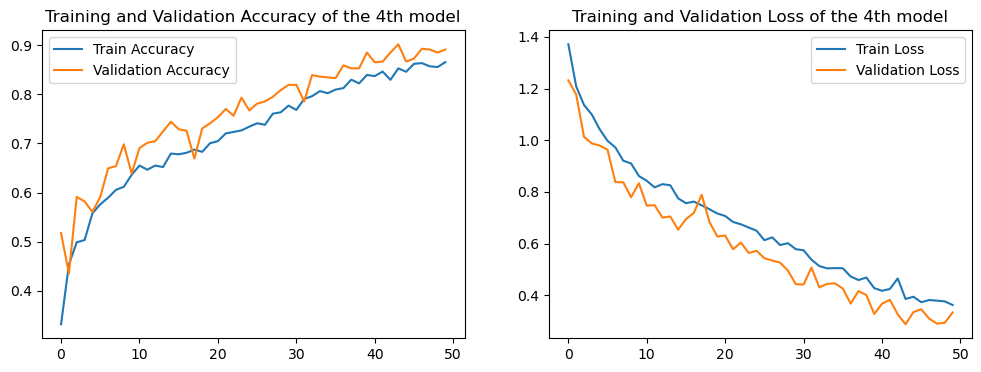

In [35]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tuned_history4.history['accuracy'], label='Train Accuracy')
plt.plot(tuned_history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of the 4th model')

plt.subplot(1, 2, 2)
plt.plot(tuned_history4.history['loss'], label='Train Loss')
plt.plot(tuned_history4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss of the 4th model')

# Save the figure
plt.savefig('fourth_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
y_pred = tuned_model4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 6ms/step


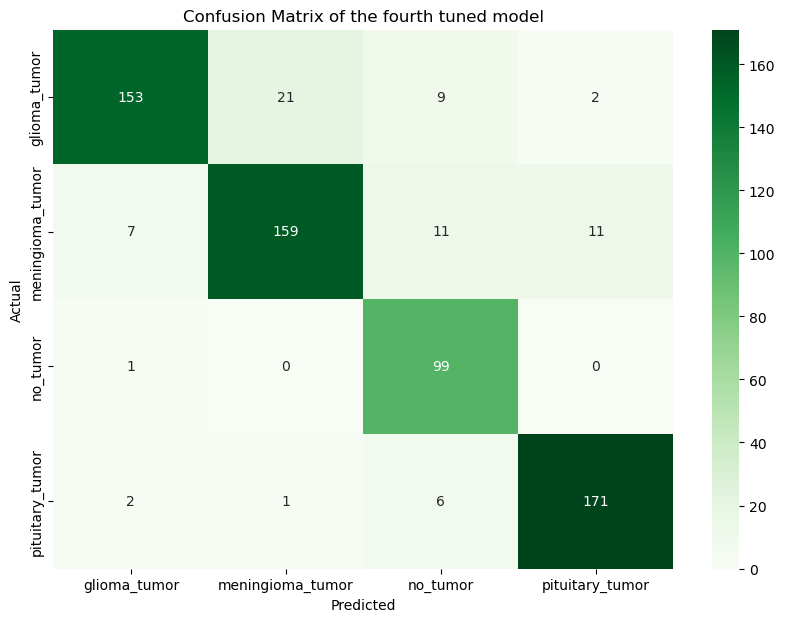

In [37]:
# The fourth tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the fourth tuned model')
# Save the figure
plt.savefig('fourth_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# The fourth tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.83      0.88       185
meningioma_tumor       0.88      0.85      0.86       188
        no_tumor       0.79      0.99      0.88       100
 pituitary_tumor       0.93      0.95      0.94       180

        accuracy                           0.89       653
       macro avg       0.88      0.90      0.89       653
    weighted avg       0.90      0.89      0.89       653



### OBSERVATION: 

## Tuned Model 5: 
**Reduced Regularization** Dropout 0.5

**Optimizer** Adam

**Learning** Adam learning rate 0.0001  

**Batch size** 16

**Convolutional layers** 4 conv blocks 64, 128, 256, 512 and dense layer of 512

**Epochs** 50 

In [39]:
tuned_model5 = Sequential()

tuned_model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model5.add(MaxPooling2D(2, 2))

tuned_model5.add(Conv2D(128, (3, 3), activation='relu'))
tuned_model5.add(MaxPooling2D(2, 2))

tuned_model5.add(Conv2D(256, (3, 3), activation='relu'))
tuned_model5.add(MaxPooling2D(2, 2))

tuned_model5.add(Conv2D(512, (3, 3), activation='relu'))
tuned_model5.add(MaxPooling2D(2, 2))

tuned_model5.add(Flatten())
tuned_model5.add(Dense(512, activation='relu'))
tuned_model5.add(Dropout(0.5))
tuned_model5.add(Dense(4, activation='softmax')) # 4 classes hence the softmax activation function 

tuned_model5.summary()

# Create an instance of the Adam optimizer
optimizer = Adam(learning_rate=0.0001)  # Using a learning rate of 0.0001
tuned_model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

start_time = time.time()

tuned_history5 = tuned_model5.fit(datagen.flow(X_train, y_train_onehot, batch_size=16),
                             validation_data=(X_test, y_test_onehot),
                             epochs=50,
                             callbacks=[checkpoint], 
                             verbose=1)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The fifth Tuned model training took {minutes} minutes and {seconds} seconds")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 17, 17, 256)     

Epoch 42/50
164/164 [==============================] - 10s 63ms/step - loss: 0.3872 - accuracy: 0.8522 - val_loss: 0.6653 - val_accuracy: 0.7534
Epoch 43/50
164/164 [==============================] - 10s 62ms/step - loss: 0.3987 - accuracy: 0.8437 - val_loss: 0.3249 - val_accuracy: 0.8622
Epoch 44/50
164/164 [==============================] - 11s 64ms/step - loss: 0.3670 - accuracy: 0.8675 - val_loss: 0.3451 - val_accuracy: 0.8775
Epoch 45/50
164/164 [==============================] - 11s 64ms/step - loss: 0.3724 - accuracy: 0.8679 - val_loss: 0.4064 - val_accuracy: 0.8438
Epoch 46/50
164/164 [==============================] - 10s 63ms/step - loss: 0.3704 - accuracy: 0.8617 - val_loss: 0.3346 - val_accuracy: 0.8760
Epoch 47/50
164/164 [==============================] - 10s 62ms/step - loss: 0.3576 - accuracy: 0.8675 - val_loss: 0.4274 - val_accuracy: 0.8392
Epoch 48/50
164/164 [==============================] - 10s 63ms/step - loss: 0.3607 - accuracy: 0.8637 - val_loss: 0.3605 - val_ac

In [40]:
# Validation accuracy and loss
val_loss, val_acc = tuned_model5.evaluate(X_test, y_test_onehot)
print(f"The fifth Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"The fifth Tuned Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 7ms/step - loss: 0.3421 - accuracy: 0.8836
The fifth Tuned Model Validation accuracy: 88.36%
The fifth Tuned Model Validation loss: 0.3421


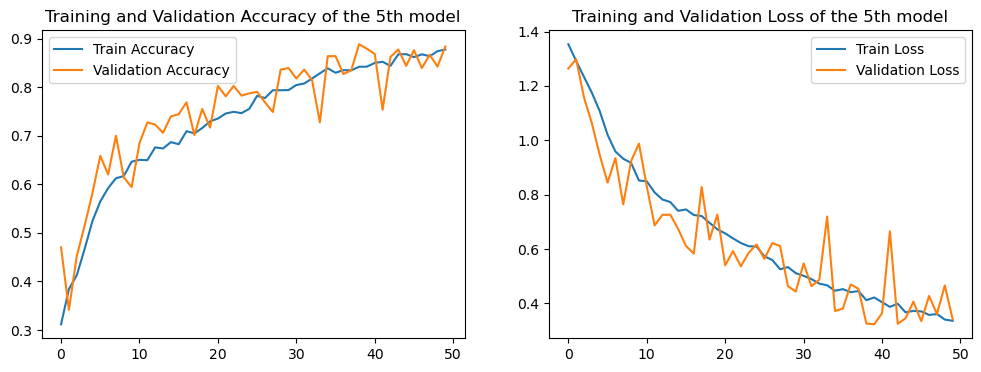

In [41]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tuned_history5.history['accuracy'], label='Train Accuracy')
plt.plot(tuned_history5.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of the 5th model')

plt.subplot(1, 2, 2)
plt.plot(tuned_history5.history['loss'], label='Train Loss')
plt.plot(tuned_history5.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss of the 5th model')

# Save the figure
plt.savefig('fifth_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [42]:
y_pred = tuned_model5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 6ms/step


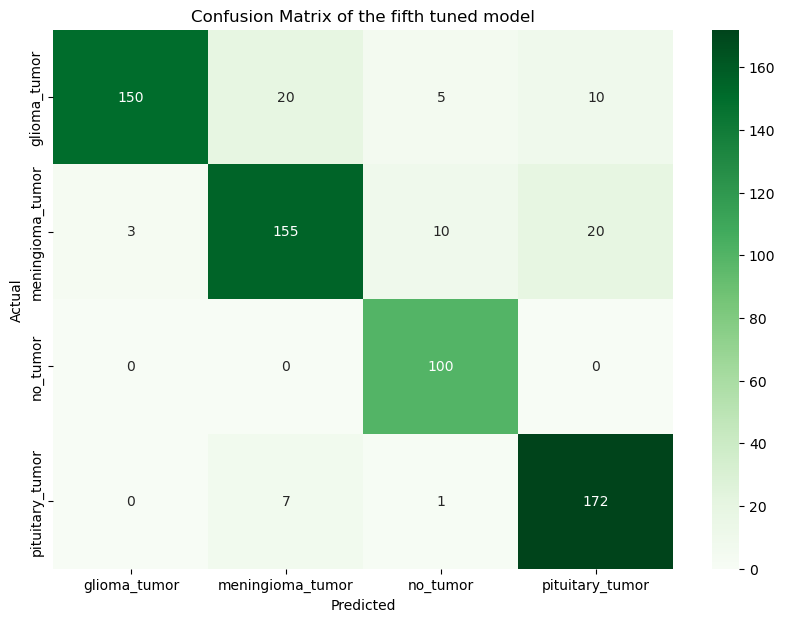

In [43]:
# The fifth tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the fifth tuned model')
# Save the figure
plt.savefig('fifth_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# The fifth tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.81      0.89       185
meningioma_tumor       0.85      0.82      0.84       188
        no_tumor       0.86      1.00      0.93       100
 pituitary_tumor       0.85      0.96      0.90       180

        accuracy                           0.88       653
       macro avg       0.89      0.90      0.89       653
    weighted avg       0.89      0.88      0.88       653



### OBSERVATION:

## Tuned Model 6: - Optimizing model 4

**Data Augmentation**

**Reduced Regularization** Dropout 0.5

**Optimizer** Adam

**Learning** Adam default learning rate 0.001  

**Batch size** 32

**Convolutional layers** 5 conv blocks 32, 64, 128, 256, 512 and dense layer of 512

**Epochs** 50

In [62]:
tuned_model6 = Sequential()

tuned_model6.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model6.add(MaxPooling2D(2, 2))

tuned_model6.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
tuned_model6.add(MaxPooling2D(2, 2))

tuned_model6.add(Conv2D(128, (3, 3), activation='relu'))
tuned_model6.add(MaxPooling2D(2, 2))

tuned_model6.add(Conv2D(256, (3, 3), activation='relu'))
tuned_model6.add(MaxPooling2D(2, 2))

tuned_model6.add(Conv2D(512, (3, 3), activation='relu'))
tuned_model6.add(MaxPooling2D(2, 2))

tuned_model6.add(Flatten())
tuned_model6.add(Dense(512, activation='relu'))
tuned_model6.add(Dropout(0.5))
tuned_model6.add(Dense(4, activation='softmax')) # 4 classes hence the softmax activation function 

tuned_model6.summary()

tuned_model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

start_time = time.time()

tuned_history6 = tuned_model6.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                             validation_data=(X_test, y_test_onehot),
                             epochs=50,
                             callbacks=[checkpoint], 
                             verbose=1)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The sixth Tuned model training took {minutes} minutes and {seconds} seconds")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 17, 17, 128)     

Epoch 40/50
82/82 [==============================] - 10s 126ms/step - loss: 0.2867 - accuracy: 0.8928 - val_loss: 0.2110 - val_accuracy: 0.9280
Epoch 41/50
82/82 [==============================] - 10s 124ms/step - loss: 0.2936 - accuracy: 0.8951 - val_loss: 0.2377 - val_accuracy: 0.9142
Epoch 42/50
82/82 [==============================] - 10s 125ms/step - loss: 0.2890 - accuracy: 0.8985 - val_loss: 0.2453 - val_accuracy: 0.9112
Epoch 43/50
82/82 [==============================] - 10s 123ms/step - loss: 0.2608 - accuracy: 0.9065 - val_loss: 0.2930 - val_accuracy: 0.8959
Epoch 44/50
82/82 [==============================] - 10s 125ms/step - loss: 0.2707 - accuracy: 0.8928 - val_loss: 0.2345 - val_accuracy: 0.9204
Epoch 45/50
82/82 [==============================] - 10s 124ms/step - loss: 0.2737 - accuracy: 0.8989 - val_loss: 0.2580 - val_accuracy: 0.8974
Epoch 46/50
82/82 [==============================] - 10s 125ms/step - loss: 0.2680 - accuracy: 0.9050 - val_loss: 0.3110 - val_accuracy:

In [69]:
# Validation accuracy and loss
val_loss, val_acc = tuned_model6.evaluate(X_test, y_test_onehot)
print(f"The sixth Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"The sixth Tuned Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 6ms/step - loss: 0.2094 - accuracy: 0.9158
The sixth Tuned Model Validation accuracy: 91.58%
The sixth Tuned Model Validation loss: 0.2094


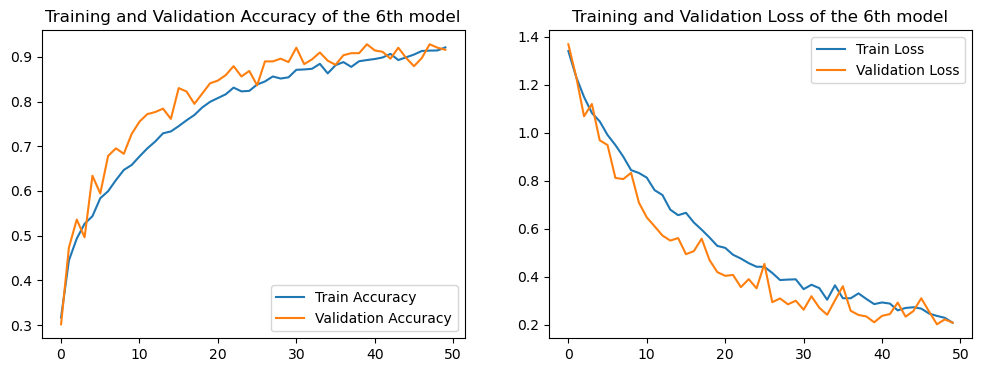

In [64]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(tuned_history6.history['accuracy'], label='Train Accuracy')
plt.plot(tuned_history6.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of the 6th model')

plt.subplot(1, 2, 2)
plt.plot(tuned_history6.history['loss'], label='Train Loss')
plt.plot(tuned_history6.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss of the 6th model')

# Save the figure
plt.savefig('sixth_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [65]:
y_pred = tuned_model6.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 5ms/step


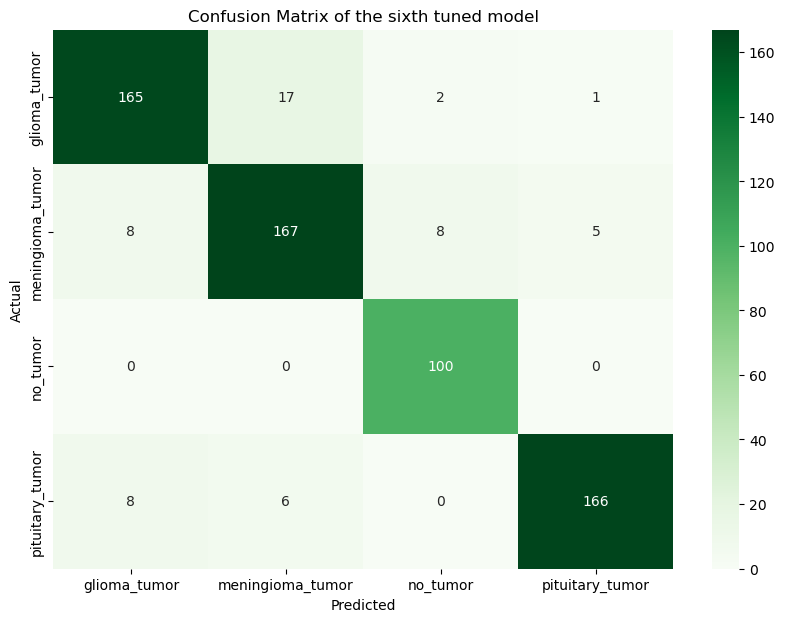

In [66]:
# The sixth tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the sixth tuned model')
# Save the figure
plt.savefig('sixth_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
# The fifth tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.89      0.90       185
meningioma_tumor       0.88      0.89      0.88       188
        no_tumor       0.91      1.00      0.95       100
 pituitary_tumor       0.97      0.92      0.94       180

        accuracy                           0.92       653
       macro avg       0.92      0.93      0.92       653
    weighted avg       0.92      0.92      0.92       653



### OBSERVATION

## Tuned Model 7: - Optimizing model 6

**Data Augmentation**

**Reduced Regularization** Dropout 0.5

**Optimizer** Adam

**Learning** Adam default learning rate 0.001  

**Batch size** 32

**Convolutional layers** 5 conv blocks 32, 64, 128, 256, 512 and dense layer of 512

**Epochs** 40

In [70]:
final_tuned_model = Sequential()

final_tuned_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
final_tuned_model.add(MaxPooling2D(2, 2))

final_tuned_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
final_tuned_model.add(MaxPooling2D(2, 2))

final_tuned_model.add(Conv2D(128, (3, 3), activation='relu'))
final_tuned_model.add(MaxPooling2D(2, 2))

final_tuned_model.add(Conv2D(256, (3, 3), activation='relu'))
final_tuned_model.add(MaxPooling2D(2, 2))

final_tuned_model.add(Conv2D(512, (3, 3), activation='relu'))
final_tuned_model.add(MaxPooling2D(2, 2))

final_tuned_model.add(Flatten())
final_tuned_model.add(Dense(512, activation='relu'))
final_tuned_model.add(Dropout(0.5))
final_tuned_model.add(Dense(4, activation='softmax')) # 4 classes hence the softmax activation function 

final_tuned_model.summary()

final_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model with the best validation loss
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

start_time = time.time()

final_tuned_history = final_tuned_model.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                             validation_data=(X_test, y_test_onehot),
                             epochs=40,
                             callbacks=[checkpoint], 
                             verbose=1)
end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The final Tuned model training took {minutes} minutes and {seconds} seconds")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 17, 17, 128)     

Epoch 40/40
82/82 [==============================] - 10s 125ms/step - loss: 0.3632 - accuracy: 0.8633 - val_loss: 0.2959 - val_accuracy: 0.8867
The final Tuned model training took 6 minutes and 58 seconds


In [71]:
# Validation accuracy and loss
val_loss, val_acc = final_tuned_model.evaluate(X_test, y_test_onehot)
print(f"The final Tuned Model Validation accuracy: {val_acc*100:.2f}%")
print(f"The final Tuned Model Validation loss: {val_loss:.4f}")


21/21 [==============================] - 0s 6ms/step - loss: 0.2959 - accuracy: 0.8867
The final Tuned Model Validation accuracy: 88.67%
The final Tuned Model Validation loss: 0.2959


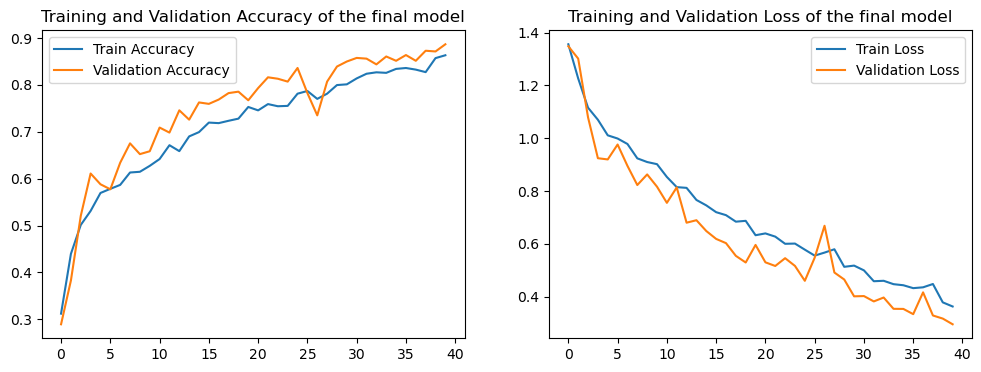

In [72]:
# Plotting Training & Validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_tuned_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_tuned_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of the final model')

plt.subplot(1, 2, 2)
plt.plot(final_tuned_history.history['loss'], label='Train Loss')
plt.plot(final_tuned_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss of the final model')

# Save the figure
plt.savefig('final_tuned_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [73]:
y_pred = final_tuned_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # This converts the one-hot encoded predictions to label indices
y_true = np.argmax(y_test_onehot, axis=1)  


21/21 [==============================] - 0s 4ms/step


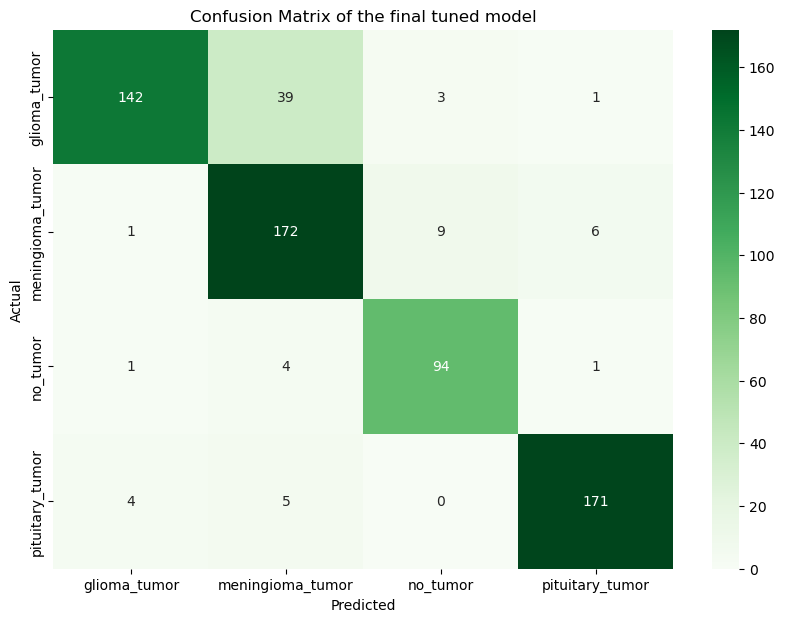

In [74]:
# The final tuned model's Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the final tuned model')
# Save the figure
plt.savefig('final_tuned_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
# The final tuned model's classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.77      0.85       185
meningioma_tumor       0.78      0.91      0.84       188
        no_tumor       0.89      0.94      0.91       100
 pituitary_tumor       0.96      0.95      0.95       180

        accuracy                           0.89       653
       macro avg       0.90      0.89      0.89       653
    weighted avg       0.90      0.89      0.89       653



### OBSERVATION:



**INCEPTION V3**

**EFFICIENTNET B0**

**EFFICIENTNET B7**

Most architectures make use of GlobalAveragePooling2D instead of flattening to reduce the number of parameters and hence make the model less prone to overfitting.
A dropout layer is added after the dense layer in some architectures to further prevent overfitting.
Models like EfficientNets and Inception already have dropouts built into them, so they might not require additional dropout layers.

## TRANSFER LEARNING

### VGG16 

In [21]:
# Load the VGG16 network with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

vgg16_model = Sequential()
vgg16_model.add(base_model)
vgg16_model.add(GlobalAveragePooling2D())
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(4, activation='softmax'))

vgg16_model.summary()

optimizer = Adam(learning_rate=0.001)

vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Use a combination of callbacks to manage learning rate and stopping criteria
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

vgg16_history = vgg16_model.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                          validation_data=(X_test, y_test_onehot),
                          epochs=50,
                          callbacks=callbacks,
                          verbose=1)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 4)                

Epoch 42/50
82/82 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.8024
Epoch 42: ReduceLROnPlateau reducing learning rate to 1e-05.
Restoring model weights from the end of the best epoch: 32.
82/82 [==============================] - 11s 129ms/step - loss: 0.5166 - accuracy: 0.8024 - val_loss: 0.4180 - val_accuracy: 0.8484 - lr: 4.0000e-05
Epoch 42: early stopping


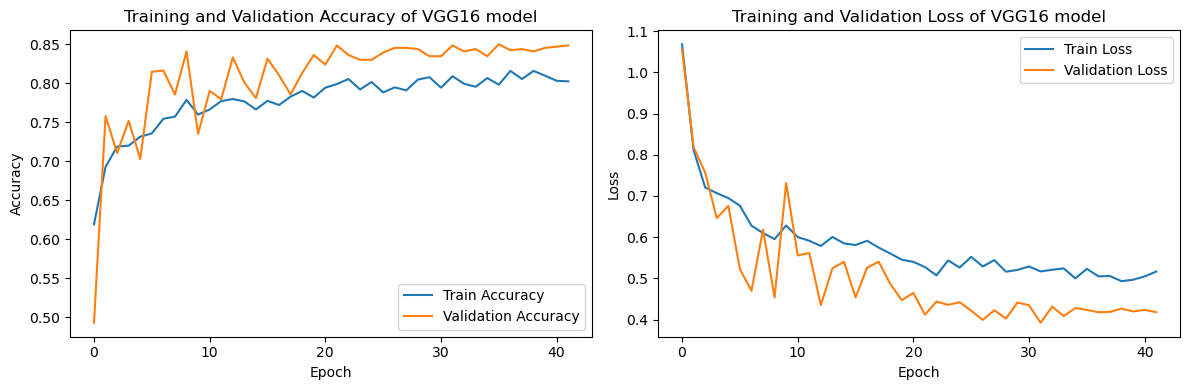

In [33]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16 model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of VGG16 model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('VGG16_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 0s 16ms/step


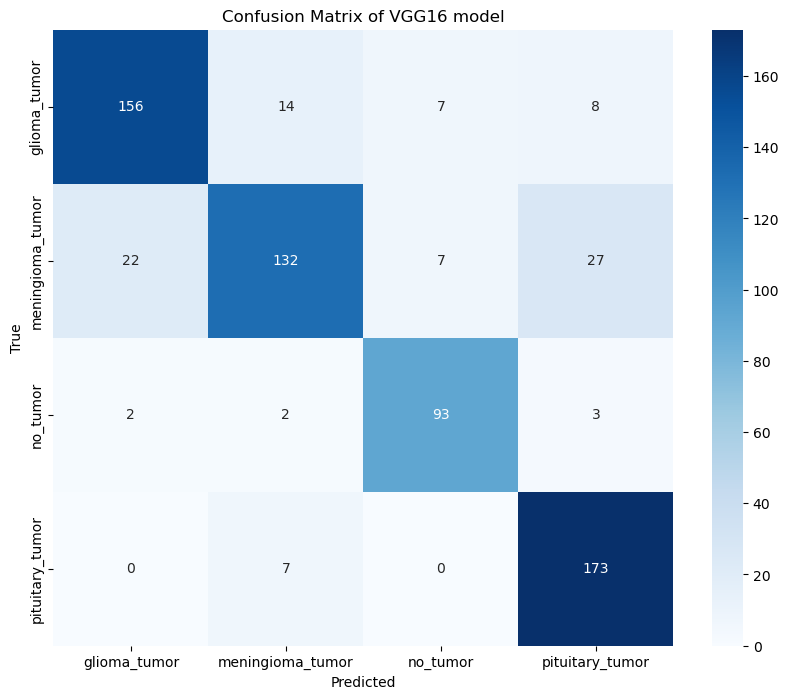

In [35]:
#VGG16  confusion matrix

# Predict classes using the model
y_pred = vgg16_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of VGG16 model')
# Save the figure
plt.savefig('VGG16_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
# VGG16 classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.84      0.85       185
meningioma_tumor       0.85      0.70      0.77       188
        no_tumor       0.87      0.93      0.90       100
 pituitary_tumor       0.82      0.96      0.88       180

        accuracy                           0.85       653
       macro avg       0.85      0.86      0.85       653
    weighted avg       0.85      0.85      0.85       653



#### OBSERVATION

### RESNET50

In [11]:
# Load the ResNet50 network
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Fine-tuning: Unfreeze the last few layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

resnet_model = Sequential()
resnet_model.add(base_model)
resnet_model.add(GlobalAveragePooling2D())

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.0001) # Reduced learning rate
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

start_time = time.time()

resnet_history = resnet_model.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                    validation_data=(X_test, y_test_onehot),
                    epochs=50,
                    callbacks=[checkpoint, reduce_lr, early_stopping], 
                    verbose=1)

end_time = time.time()

elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"The ResNet50 model training took {minutes} minutes and {seconds} seconds")


Epoch 1/50
82/82 [==============================] - 28s 167ms/step - loss: 1.3024 - accuracy: 0.3964 - val_loss: 1.4176 - val_accuracy: 0.2986 - lr: 1.0000e-04
Epoch 2/50
82/82 [==============================] - 11s 134ms/step - loss: 1.1668 - accuracy: 0.4650 - val_loss: 2.1503 - val_accuracy: 0.2864 - lr: 1.0000e-04
Epoch 3/50
82/82 [==============================] - 11s 132ms/step - loss: 1.1290 - accuracy: 0.4941 - val_loss: 2.6166 - val_accuracy: 0.2971 - lr: 1.0000e-04
Epoch 4/50
82/82 [==============================] - 11s 131ms/step - loss: 1.0739 - accuracy: 0.5354 - val_loss: 2.3238 - val_accuracy: 0.3415 - lr: 1.0000e-04
Epoch 5/50
82/82 [==============================] - 11s 131ms/step - loss: 1.0577 - accuracy: 0.5366 - val_loss: 1.6013 - val_accuracy: 0.3920 - lr: 1.0000e-04
Epoch 6/50
82/82 [==============================] - 11s 137ms/step - loss: 1.0524 - accuracy: 0.5377 - val_loss: 1.0123 - val_accuracy: 0.5620 - lr: 1.0000e-04
Epoch 7/50
82/82 [======================

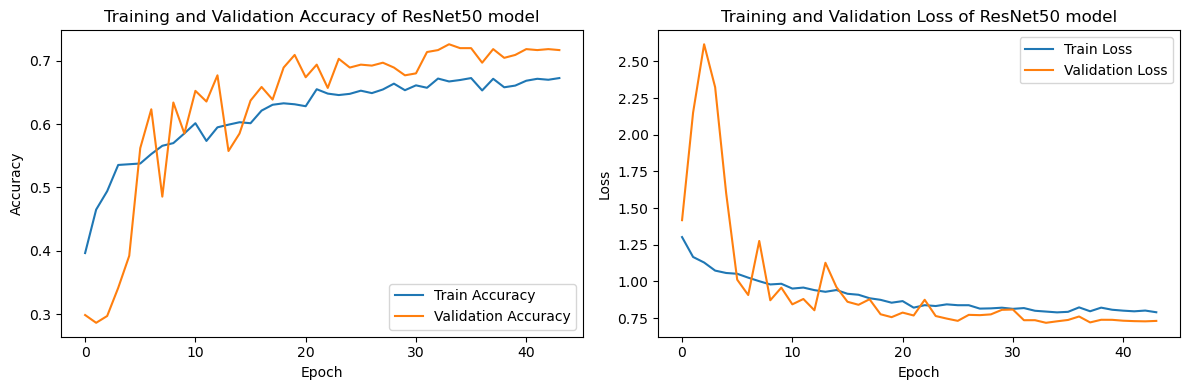

In [12]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of ResNet50 model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of ResNet50 model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('ResNet50_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 1s 17ms/step


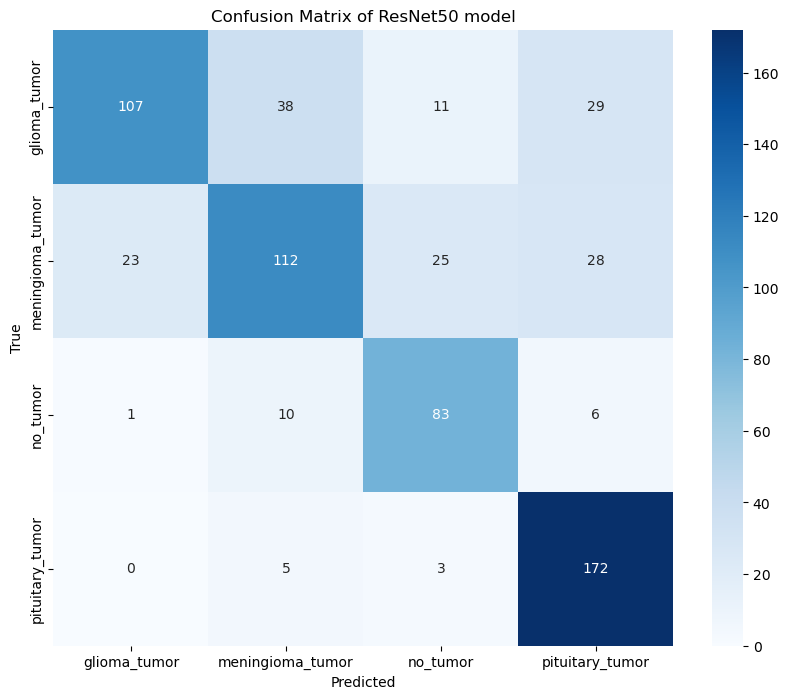

In [13]:
#ResNet confusion matrix

# Predict classes using the model
y_pred = resnet_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of ResNet50 model')
# Save the figure
plt.savefig('ResNet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# ResNet50 classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.82      0.58      0.68       185
meningioma_tumor       0.68      0.60      0.63       188
        no_tumor       0.68      0.83      0.75       100
 pituitary_tumor       0.73      0.96      0.83       180

        accuracy                           0.73       653
       macro avg       0.73      0.74      0.72       653
    weighted avg       0.73      0.73      0.72       653



#### OBSERVATION:

### INCEPTION V3

In [16]:
# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers 
for layer in base_model.layers:
    layer.trainable = False

inception_model = Sequential()
inception_model.add(base_model)
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

inception_history = inception_model.fit(datagen.flow(X_train, y_train_onehot, batch_size=32),
                    validation_data=(X_test, y_test_onehot),
                    epochs=50,
                    callbacks=[checkpoint, reduce_lr, early_stopping], 
                    verbose=1)


Epoch 1/50
82/82 [==============================] - 19s 172ms/step - loss: 1.5359 - accuracy: 0.4546 - val_loss: 0.7367 - val_accuracy: 0.7228 - lr: 1.0000e-04
Epoch 2/50
82/82 [==============================] - 11s 140ms/step - loss: 0.9703 - accuracy: 0.6013 - val_loss: 0.6990 - val_accuracy: 0.7397 - lr: 1.0000e-04
Epoch 3/50
82/82 [==============================] - 11s 136ms/step - loss: 0.8497 - accuracy: 0.6641 - val_loss: 0.6482 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 4/50
82/82 [==============================] - 11s 136ms/step - loss: 0.7895 - accuracy: 0.6829 - val_loss: 0.6185 - val_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 5/50
82/82 [==============================] - 11s 138ms/step - loss: 0.7526 - accuracy: 0.6974 - val_loss: 0.6160 - val_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 6/50
82/82 [==============================] - 11s 138ms/step - loss: 0.7348 - accuracy: 0.7105 - val_loss: 0.6116 - val_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 7/50
82/82 [======================

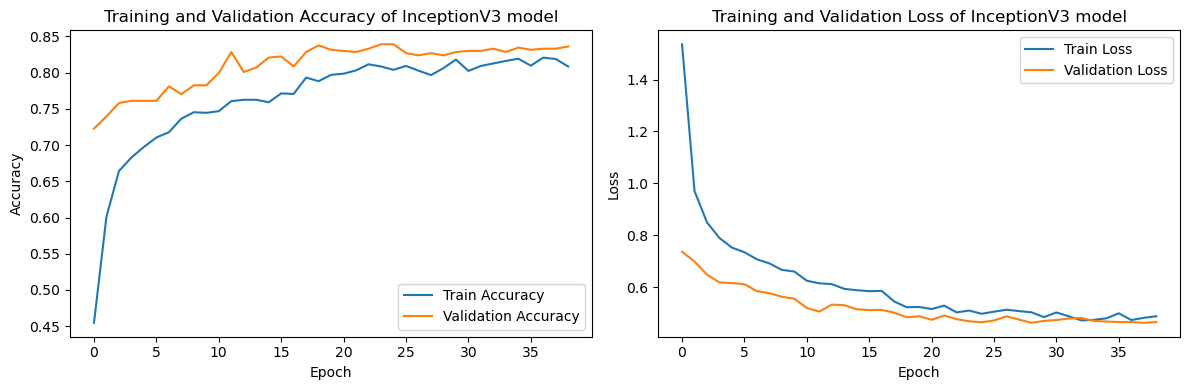

In [20]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(inception_history.history['accuracy'], label='Train Accuracy')
plt.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of InceptionV3 model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(inception_history.history['loss'], label='Train Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of InceptionV3 model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('InceptionV3_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 1s 11ms/step


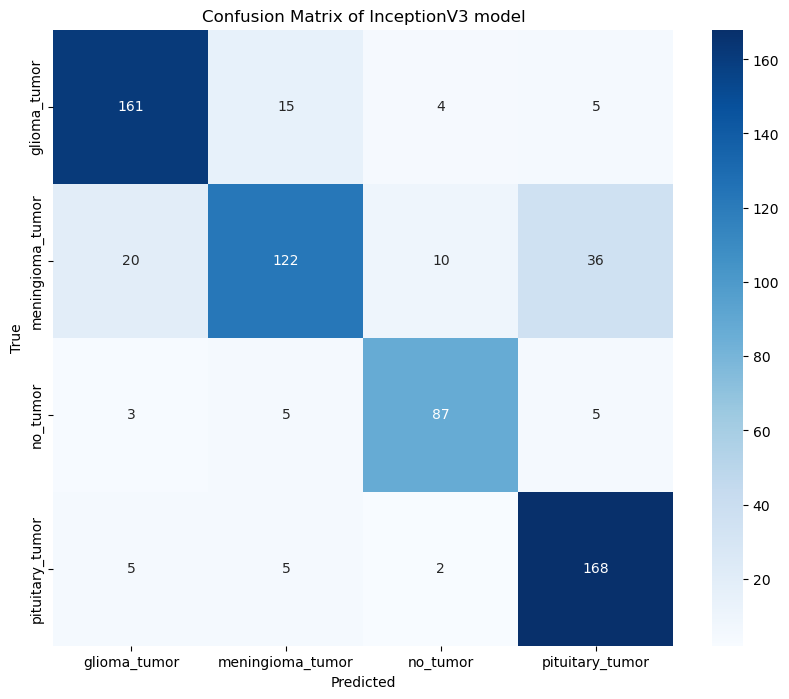

In [21]:
#InceptionV3 confusion matrix

# Predict classes using the model
y_pred = inception_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of InceptionV3 model')
# Save the figure
plt.savefig('InceptionV3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# InceptionV3 classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.87      0.86       185
meningioma_tumor       0.83      0.65      0.73       188
        no_tumor       0.84      0.87      0.86       100
 pituitary_tumor       0.79      0.93      0.85       180

        accuracy                           0.82       653
       macro avg       0.83      0.83      0.82       653
    weighted avg       0.83      0.82      0.82       653



### OBSERVATIONS:

### EFFICIENTNET B2

In [42]:
# Set the input shape
input_shape = (150, 150, 3)

# Define the base model
b2_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

# Build the actual model
b2_model = Sequential()
b2_model.add(b2_base)
b2_model.add(Flatten())
b2_model.add(Dense(1024, activation='relu'))
b2_model.add(Dropout(0.5))  # Adding dropout to reduce overfitting
b2_model.add(Dense(4, activation='softmax'))  

# Compiling the model
b2_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

# Training the model 
b2_history = b2_model.fit(
    X_train, y_train_onehot,
    validation_data=(X_test, y_test_onehot),
    epochs=20,
    callbacks=callbacks, 
    verbose=1
)

# Saving the model weights for my use in the future
b2_model.save_weights('EfficientNetB2_best_weights.h5')


Epoch 1/20


2023-09-10 09:28:41.517743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 65s 122ms/step - loss: 0.8932 - accuracy: 0.7009 - val_loss: 2.0720 - val_accuracy: 0.1440 - lr: 1.0000e-04
Epoch 2/20
82/82 [==============================] - 7s 86ms/step - loss: 0.2787 - accuracy: 0.9004 - val_loss: 2.8522 - val_accuracy: 0.1516 - lr: 1.0000e-04
Epoch 3/20
82/82 [==============================] - 7s 88ms/step - loss: 0.1567 - accuracy: 0.9426 - val_loss: 3.5595 - val_accuracy: 0.1531 - lr: 1.0000e-04
Epoch 4/20
82/82 [==============================] - 7s 88ms/step - loss: 0.1110 - accuracy: 0.9621 - val_loss: 3.0233 - val_accuracy: 0.1975 - lr: 1.0000e-04
Epoch 5/20
82/82 [==============================] - 7s 89ms/step - loss: 0.0671 - accuracy: 0.9743 - val_loss: 3.8203 - val_accuracy: 0.2098 - lr: 1.0000e-04
Epoch 6/20
82/82 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9816
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-05.
82/82 [==============================] - 7s 89ms/step - loss: 0.0

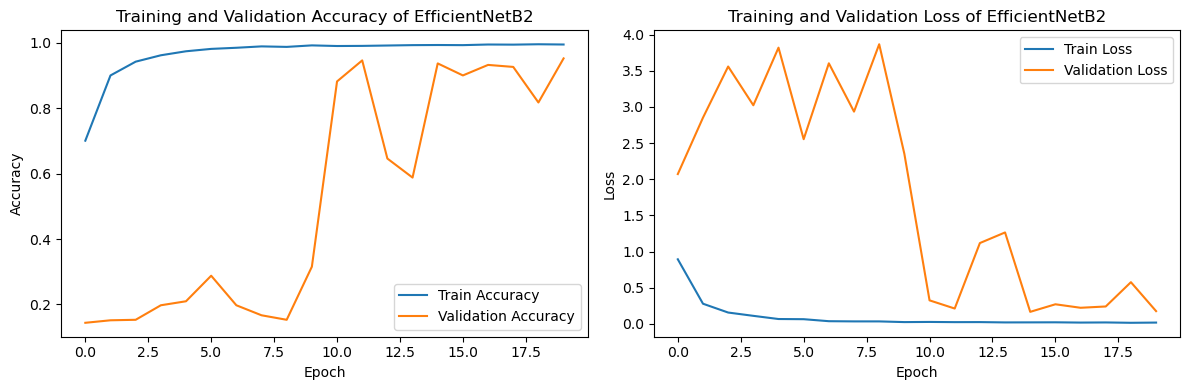

In [84]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(b2_history.history['accuracy'], label='Train Accuracy')
plt.plot(b2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of EfficientNetB2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(b2_history.history['loss'], label='Train Loss')
plt.plot(b2_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of EfficientNetB2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('EfficientNetB2_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 3s 19ms/step


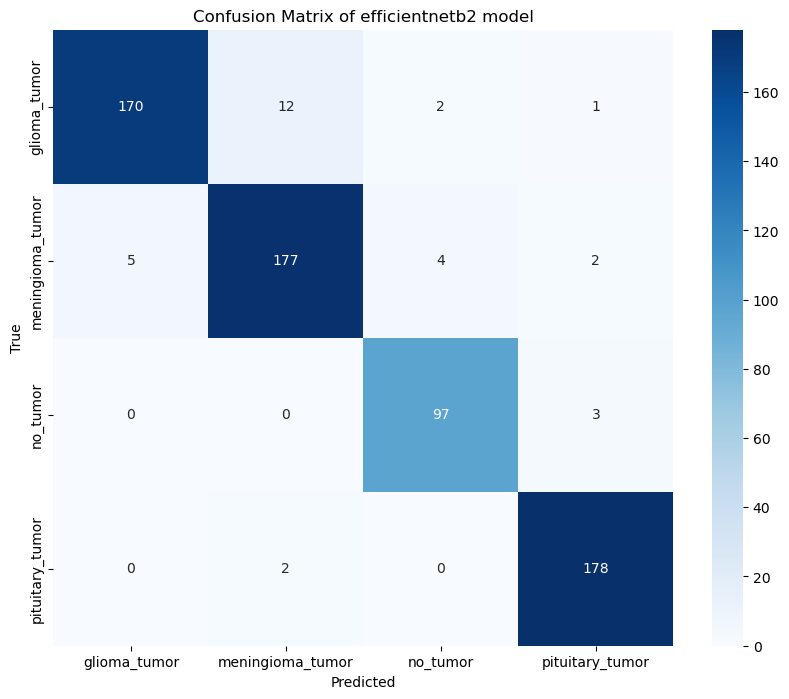

In [85]:
#InceptionV3 confusion matrix

# Predict classes using the model
y_pred = b2_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of efficientnetb2 model')
# Save the figure
plt.savefig('Efficientnetb2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [86]:
# EfficientNetB2 classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.92      0.94       185
meningioma_tumor       0.93      0.94      0.93       188
        no_tumor       0.94      0.97      0.96       100
 pituitary_tumor       0.97      0.99      0.98       180

        accuracy                           0.95       653
       macro avg       0.95      0.95      0.95       653
    weighted avg       0.95      0.95      0.95       653



In [ ]:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

### VGG19

In [68]:
input_shape = (150, 150, 3) # the input data

# Load the VGG19 model with its pre-trained ImageNet weights
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Make the VGG19 base model non-trainable by freezing the layers
for layer in vgg19_base.layers:
    layer.trainable = False

# Initialize a sequential model
vgg19_model3 = Sequential()

# Add the base VGG19 model to our sequential model
vgg19_model3.add(vgg19_base)

# Flatten the output of the base model to provide input to the dense layers
vgg19_model3.add(Flatten())

# Add a fully connected layer with 256 neurons and ReLU activation function
vgg19_model3.add(Dense(512, activation='relu'))

# Add a dropout layer to reduce overfitting
vgg19_model3.add(Dropout(0.7))

# Add the output layer with 4 neurons (one for each class) using softmax activation
vgg19_model3.add(Dense(4, activation='softmax'))  


vgg19_model3.compile(optimizer = Adam(learning_rate=0.001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])
vgg19_history3 = vgg19_model3.fit(
    X_train, y_train_onehot, 
    validation_data=(X_test, y_test_onehot), 
    batch_size=32,
    epochs=50,
    verbose=1
)

Epoch 1/50
82/82 [==============================] - 4s 31ms/step - loss: 1.2564 - accuracy: 0.5324 - val_loss: 0.7728 - val_accuracy: 0.7152
Epoch 2/50
82/82 [==============================] - 2s 26ms/step - loss: 0.8364 - accuracy: 0.6591 - val_loss: 0.6716 - val_accuracy: 0.7657
Epoch 3/50
82/82 [==============================] - 2s 26ms/step - loss: 0.7843 - accuracy: 0.6760 - val_loss: 0.6824 - val_accuracy: 0.6692
Epoch 4/50
82/82 [==============================] - 2s 26ms/step - loss: 0.7329 - accuracy: 0.6925 - val_loss: 0.6151 - val_accuracy: 0.7779
Epoch 5/50
82/82 [==============================] - 2s 27ms/step - loss: 0.6893 - accuracy: 0.7281 - val_loss: 0.5713 - val_accuracy: 0.7749
Epoch 6/50
82/82 [==============================] - 2s 26ms/step - loss: 0.6678 - accuracy: 0.7315 - val_loss: 0.4951 - val_accuracy: 0.8147
Epoch 7/50
82/82 [==============================] - 2s 26ms/step - loss: 0.6254 - accuracy: 0.7296 - val_loss: 0.4738 - val_accuracy: 0.8254
Epoch 8/50
82

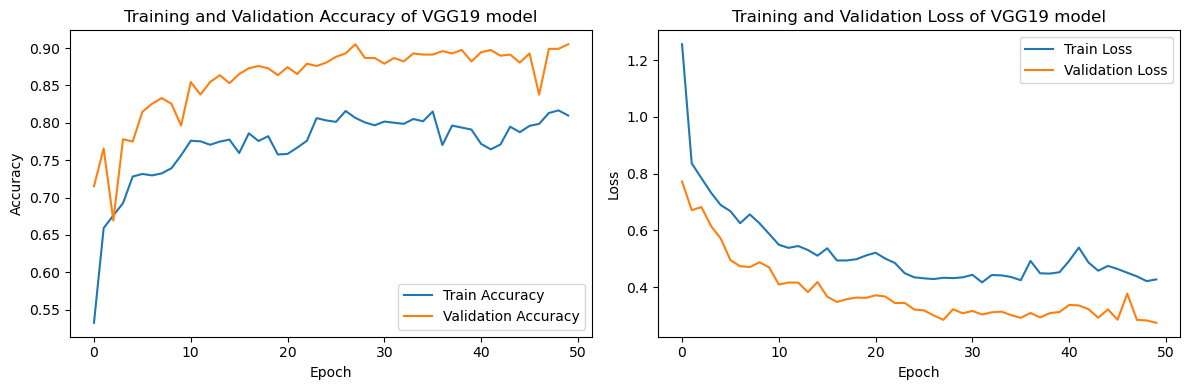

In [81]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vgg19_history3.history['accuracy'], label='Train Accuracy')
plt.plot(vgg19_history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG19 model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg19_history3.history['loss'], label='Train Loss')
plt.plot(vgg19_history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of VGG19 model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('Vgg19_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 1s 18ms/step


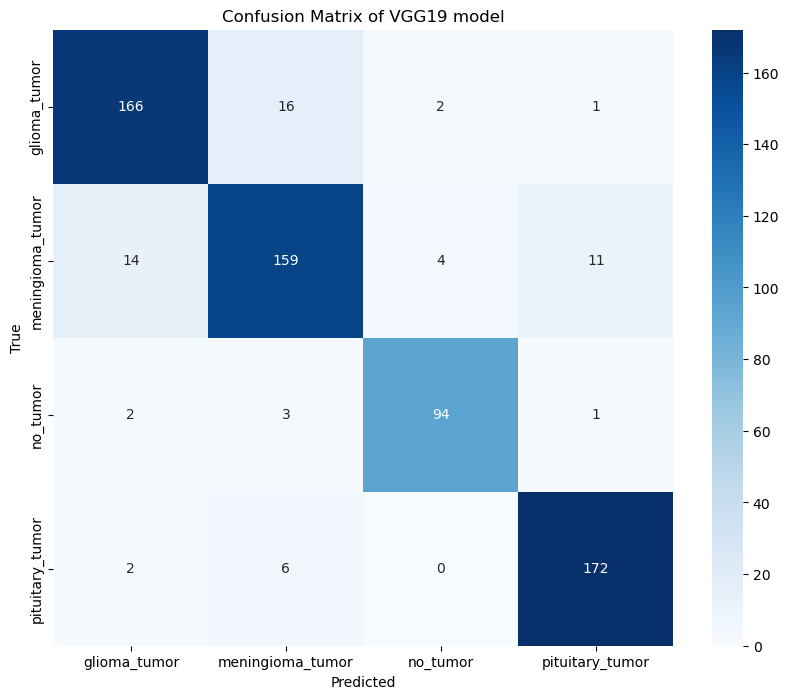

In [82]:
#VGG19 epochs confusion matrix

# Predict classes using the model
y_pred = vgg19_model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of VGG19 model')
# Save the figure
plt.savefig('VGG19_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# VGG19 classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.90      0.90       185
meningioma_tumor       0.86      0.85      0.85       188
        no_tumor       0.94      0.94      0.94       100
 pituitary_tumor       0.93      0.96      0.94       180

        accuracy                           0.91       653
       macro avg       0.91      0.91      0.91       653
    weighted avg       0.90      0.91      0.90       653



## VGG16 enhanced

In [73]:
# Load the VGG16 network with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

vgg16_model4 = Sequential()
vgg16_model4.add(base_model)
vgg16_model4.add(GlobalAveragePooling2D())
vgg16_model4.add(Dense(1024, activation='relu'))
vgg16_model4.add(BatchNormalization())
vgg16_model4.add(Dropout(0.8))
vgg16_model4.add(Dense(4, activation='softmax'))

vgg16_model4.summary()

optimizer = Adam(learning_rate=0.0001)

vgg16_model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Use a combination of callbacks to manage learning rate and stopping criteria
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

vgg16_history4 = vgg16_model4.fit(X_train, y_train_onehot, 
    validation_data=(X_test, y_test_onehot), 
    batch_size=32,
    epochs=50,
    verbose=1)


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_15  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_75 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_384 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_34 (Dropout)        (None, 1024)              0         
                                                                 
 dense_76 (Dense)            (None, 4)               

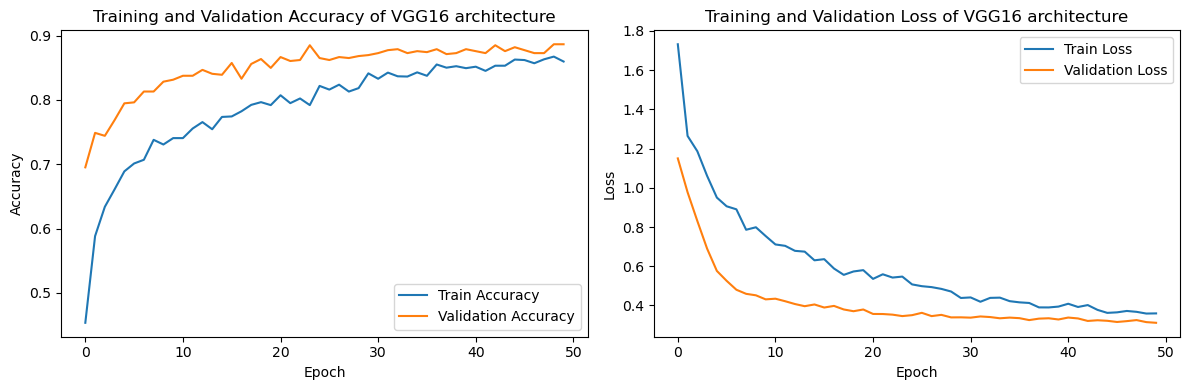

In [78]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vgg16_history4.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16 architecture')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_history4.history['loss'], label='Train Loss')
plt.plot(vgg16_history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of VGG16 architecture')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('vgg16-50_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 1s 16ms/step


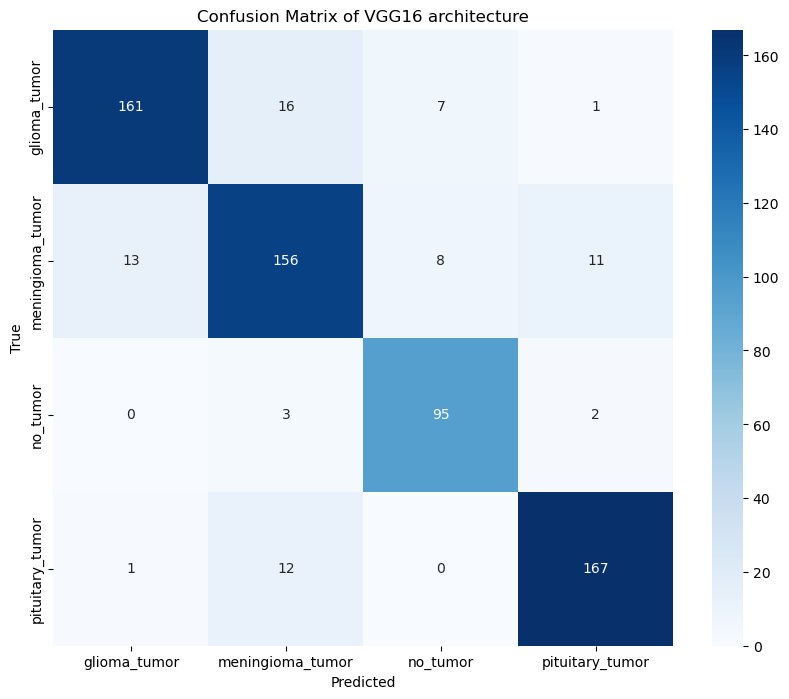

In [79]:
#VGG16 50 epochs confusion matrix

# Predict classes using the model
y_pred = vgg16_model4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of VGG16 architecture')
# Save the figure
plt.savefig('VGG16_50_ep_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# VGG16 50 epochs classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.87      0.89       185
meningioma_tumor       0.83      0.83      0.83       188
        no_tumor       0.86      0.95      0.90       100
 pituitary_tumor       0.92      0.93      0.93       180

        accuracy                           0.89       653
       macro avg       0.89      0.89      0.89       653
    weighted avg       0.89      0.89      0.89       653



### VGG16 100 EPOCHS ADAM

In [74]:
# Load the VGG16 network with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

vgg16_model5 = Sequential()
vgg16_model5.add(base_model)
vgg16_model5.add(GlobalAveragePooling2D())
vgg16_model5.add(Dense(1024, activation='relu'))
vgg16_model5.add(BatchNormalization())
vgg16_model5.add(Dropout(0.8))
vgg16_model5.add(Dense(4, activation='softmax'))

vgg16_model5.summary()

optimizer = Adam(learning_rate=0.0001)

vgg16_model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Use a combination of callbacks to manage learning rate and stopping criteria
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

vgg16_history5 = vgg16_model5.fit(X_train, y_train_onehot, 
    validation_data=(X_test, y_test_onehot), 
    batch_size=32,
    epochs=100,
    verbose=1)


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_16  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_77 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_385 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_35 (Dropout)        (None, 1024)              0         
                                                                 
 dense_78 (Dense)            (None, 4)               

Epoch 49/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3622 - accuracy: 0.8633 - val_loss: 0.3175 - val_accuracy: 0.8806
Epoch 50/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3585 - accuracy: 0.8690 - val_loss: 0.3076 - val_accuracy: 0.8760
Epoch 51/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3445 - accuracy: 0.8740 - val_loss: 0.3146 - val_accuracy: 0.8851
Epoch 52/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3449 - accuracy: 0.8686 - val_loss: 0.3151 - val_accuracy: 0.8744
Epoch 53/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3374 - accuracy: 0.8778 - val_loss: 0.3142 - val_accuracy: 0.8836
Epoch 54/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3374 - accuracy: 0.8702 - val_loss: 0.3084 - val_accuracy: 0.8836
Epoch 55/100
82/82 [==============================] - 3s 31ms/step - loss: 0.3476 - accuracy: 0.8629 - val_loss: 0.3176 - val_accuracy: 0.8836

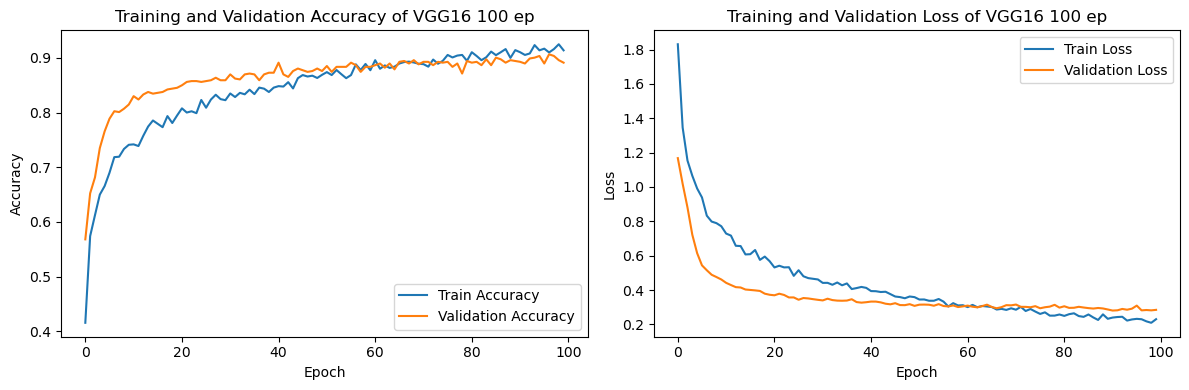

In [75]:
#Visualize training and validation accuracy & loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vgg16_history5.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG16 100 ep')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_history5.history['loss'], label='Train Loss')
plt.plot(vgg16_history5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of VGG16 100 ep')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('vgg16-100ep_model_training_validation_plot.png', dpi=300, bbox_inches='tight')
plt.show()


21/21 [==============================] - 1s 16ms/step


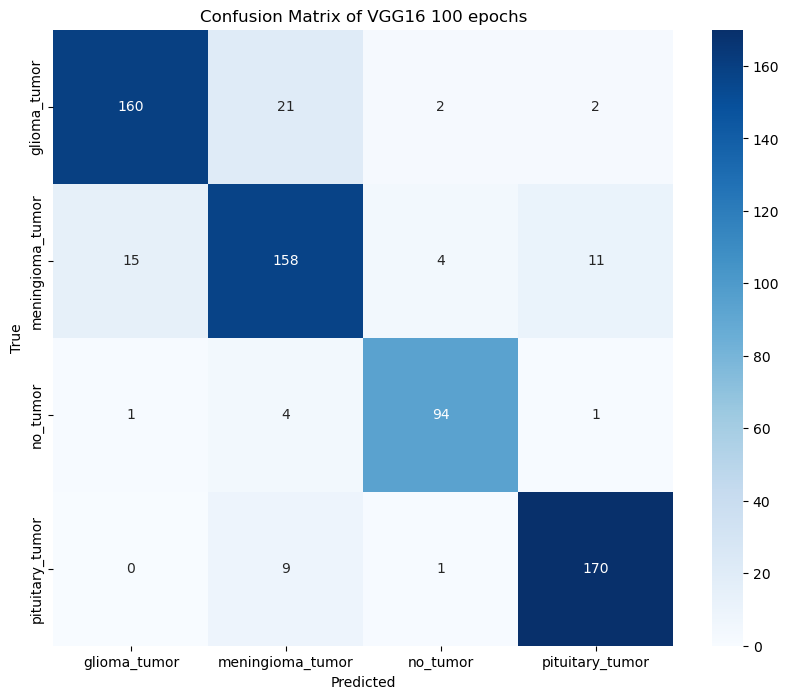

In [76]:
#VGG16 100 epochs confusion matrix

# Predict classes using the model
y_pred = vgg16_model5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of VGG16 100 epochs')
# Save the figure
plt.savefig('VGG16_100_ep_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [77]:
# VGG16 100 epochs classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.86      0.89       185
meningioma_tumor       0.82      0.84      0.83       188
        no_tumor       0.93      0.94      0.94       100
 pituitary_tumor       0.92      0.94      0.93       180

        accuracy                           0.89       653
       macro avg       0.90      0.90      0.90       653
    weighted avg       0.89      0.89      0.89       653

